# Serving up text... Shakespeare style!

### Brief: Using LSTM models to predict text based on Shakespeare sonnets. This will be based character based training rather than words

In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
f = open('shakespeare.txt','r')
all_text=f.read()
f.close()

In [4]:
set_corpus=set(all_text)

In [5]:
print(f'Length of the vocab is {len(set_corpus)}')

Length of the vocab is 84


print(all_text[:1000])

### Using characters instead of words

#### Creating integer values for each character

In [6]:
def dict_decoder(text):
    '''
    # Dict {index:letter} for every letter in text
    '''
    decoded_dict=(dict(enumerate(set(text))))
    return decoded_dict

In [7]:
decoder=dict_decoder(all_text) # Dict {index:letter} #Creating the dictionary for the decoder

In [8]:
def dict_encoder(text):
    '''
    # Dict {letter:index} for every letter in text
    '''
    dec_text= dict_decoder(text)
    encoded_dict = dict([(word,i) for i,word in dec_text.items()])
    return encoded_dict

In [9]:
def encoding_text(text,encoder):
    return [encoder[word] for word in text]
    

In [10]:
encoder= dict_encoder(all_text) #Creating the dictionary for encoder

In [11]:
encode_text=encoding_text(all_text, encoder) #Representing the corpus with encoded values

In [12]:
np.max(encode_text)

83

In [13]:
len(encode_text)

5445609

#### Create batches

##### 1. Creating individual steps before consolidating into a single function

In [14]:
window = 40
samples_per_batch=30
chars_per_batch=window*samples_per_batch

In [15]:
batch_count=int(len(encode_text)/chars_per_batch)
batch_count

4538

In [16]:
text_corp=encode_text[:batch_count*chars_per_batch]
print(len(encode_text))
print(len(text_corp))

5445609
5445600


In [17]:
np.array(text_corp).shape

(5445600,)

In [18]:
text_corp=np.array(text_corp).reshape((samples_per_batch,-1))
print(text_corp.shape)
text_corp[0].shape

(30, 181520)


(181520,)

In [19]:
batch=[]
i=0
for samp in range(0,text_corp.shape[1],window):
    x=text_corp[:,samp:samp+window]
    y = np.zeros_like(x)
    try:
        y[:,:-1]=x[:,1:]
        y[:,-1]=text_corp[:,samp+window][0]
    except:
        print('Whoopsie! Crossed index limits')
        y[:,:-1]=x[:,1:]
        y[:,-1]=text_corp[:,0][0]
    batch.append((x,y))

Whoopsie! Crossed index limits


##### 2. Consolidating all of the above into a single function

In [20]:
def create_batches(samp_encoded_text,samp_batch=30,window=40, encoder=encoder): #We have to use the encoded text directly since the train and test batches are based on encoded text
    '''
    Args:
    all_text: corpus of text
    samp_batch: how many samples of text should one batch have
    window: window, length of one sample (how many characters should be passed to the LSTM i.e. how many cells in the LSTM)
    Given a set of text:
    1. Encode the text based on the dictionary provided
    2. Based on the number of samples per batch and the length of each sequence (the window) of the sample, calculate the number of characters we get per batch i.e. chars_per_batch=window*samples_per_batch
    3. Since, we know what the total number of characters in the text is, we can find out how many batches we will get (rounded down to the lower integer value) as: batch_count = Quotient(total number of characters / characters per batch).
    4. We then take only that many characters that is an integer multiple of batch i.e. final corpus = initial corpus[batch_count*characters per batch]. Hence, we now get a list which is batch_count*window*samples_per_batch
    5. Now we can reshape this into a matrix of [samples_per_batch, window*batch_count]. Hence, this is a matrix of batch_count number of data sets each of window long stacked horizontally). We can then slice this column-wise to get all our batches of [samples_per_batch, window]
    returns:
    x: set of inputs
    y:set of outputs
    '''
    encode_samp=samp_encoded_text # Step 1 described above
#     print('len of encode_samp',len(encode_samp))
#     print('len of encode_text',len(sample_text))
    window = window #Extracting window size 
    samples_per_batch=samp_batch #Extracting samples per batch
    chars_per_batch=window*samples_per_batch #Step 2 described above
    batch_count=int(len(encode_samp)/chars_per_batch) #Step 3 described above
    final_corpus=encode_samp[:batch_count*chars_per_batch] #Step 4 described above
#     print('final corpus',final_corpus)
#     print('final corpus length',len(final_corpus))
    final_corpus = np.array(final_corpus).reshape((samples_per_batch,-1))
    
    # Slicing final_corpus to provide the batches:
    for samp in range(0,final_corpus.shape[1],window):
        x=final_corpus[:,samp:samp+window]
        y=np.zeros_like(x)
        try:
            y[:,:-1]=x[:,1:]
            y[:,-1]=final_corpus[:,samp+window]
        except:
            y[:,:-1]=x[:,1:]
            y[:,-1]=final_corpus[:,0]
        yield (x,y)

##### 3. Testing on sample data

In [21]:
sample_text = all_text[:20]

In [22]:
samp_encode=encoding_text(sample_text, encoder)

In [23]:
batches_samp=create_batches(samp_encode,samp_batch=2,window=5)

In [24]:
x, y = next(batches_samp)

In [25]:
x

array([[59, 40, 40, 40, 40],
       [40, 40, 40, 40, 40]])

In [26]:
y

array([[40, 40, 40, 40, 40],
       [40, 40, 40, 40, 40]])

#### Building the LSTM model

In [27]:
class LSTMModel(nn.Module):
    def __init__(self,text,num_hidden=256,num_layers=4,batch_first=True,dropout_prob=0.5,use_gpu=True):
        #currently the input size is [number of samples / batch, seq_len]. However, as per LSTM model, the inputs need to be given as tensor of shape (seq_len, samples/batch, input size) when batch_first=False or (samples/batch, seq_len, input_size) when batch_first=True. Hence, we can set batch_first=True and use x directly for first two dimensions. The third dimension (input size) will be generated automatically when we convert X to a one-hot coded vector)
        super().__init__()
        self.num_hidden = num_hidden
        self.num_layers=num_layers
        self.batch_first=batch_first
        self.dropout_p=dropout_prob
        self.text=text
        self.use_gpu=use_gpu
        self.lstm=nn.LSTM(input_size=len(self.text),
                             hidden_size=self.num_hidden,
                             num_layers=self.num_layers,
                             batch_first=self.batch_first, 
                             dropout=self.dropout_p)
        self.dropout=nn.Dropout(self.dropout_p)
        self.fc1=nn.Linear(num_hidden,len(self.text))
        
    def forward(self,X,hidden_input):
        output, hidden_input = self.lstm(X,hidden_input)      
        drop_out=self.dropout(output)
        drop_out=drop_out.reshape(-1,self.num_hidden)
        out=self.fc1(drop_out)
        return out, hidden_input
    
    def create_hidden(self,batch_size):
        '''As per Pytorch documentation, the hidden initial state and initial cell state need to be passed to the forward function as a tuple.
        Initial hidden state needs to be given as [num_layers,no of samples/batch, Hout - number of outputs to next hidden layer which we have all set as the same number of nodes.]
        Initial cell state needs to be given as [num_layers,no of samples/batch, Hout - number of outputs to next hidden layer which we have all set as the same number of nodes.]
        '''
        if self.use_gpu:
            hidden_input=(torch.zeros(self.num_layers,batch_size,self.num_hidden).cuda(),
                    torch.zeros(self.num_layers,batch_size,self.num_hidden).cuda())
        else:
            hidden_input=(torch.zeros(self.num_layers,batch_size,self.num_hidden),
                    torch.zeros(self.num_layers,batch_size,self.num_hidden))
        return hidden_input

In [28]:
lstm_model = LSTMModel(text=set_corpus,
                       num_hidden=512,
                       num_layers=5,
                       batch_first=True,
                       dropout_prob=0.3,
                       use_gpu=torch.cuda.is_available()
                      )
if torch.cuda.is_available():
    lstm_model.cuda()
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(lstm_model.parameters(),lr=0.0005)

In [29]:
print(lstm_model.parameters)
parame=[]
for e,parameter in enumerate(lstm_model.parameters()):
    print(f'{e}:\t {parameter.numel()}')
    parame.append(parameter.numel())
print(f'Total number of parameters: {np.array(parame).sum()}')
    

<bound method Module.parameters of LSTMModel(
  (lstm): LSTM(84, 512, num_layers=5, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=512, out_features=84, bias=True)
)>
0:	 172032
1:	 1048576
2:	 2048
3:	 2048
4:	 1048576
5:	 1048576
6:	 2048
7:	 2048
8:	 1048576
9:	 1048576
10:	 2048
11:	 2048
12:	 1048576
13:	 1048576
14:	 2048
15:	 2048
16:	 1048576
17:	 1048576
18:	 2048
19:	 2048
20:	 43008
21:	 84
Total number of parameters: 9672788


#### One-hot encoding for X as per LSTM input requirements

In [30]:
def one_hot_encoding(array,vocab_size):
    one_hot=torch.zeros(array.shape[0],array.shape[1],vocab_size)
    for a in range(array.shape[0]):
        for b in range(array.shape[1]):
            one_hot[a,b,array[a,b]]=1 
    return one_hot

In [31]:
arr=np.array([[1,2,0],[2,5,6]])
print(arr.shape)
one_hot_encoding(arr,7)

(2, 3)


tensor([[[0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 1.]]])

#### Train test split

In [32]:
#Consider using:
batch_size = 64
seq_len = 100

In [33]:
number_batches=len(all_text)/(batch_size*seq_len)
print(f' No. of batches available {int(number_batches)}')

 No. of batches available 850


<b> <i>If we have only 425 sets of data to train on, we need to maximize the train data size and minimize the test data size adequately.

In [34]:
split=.1

In [35]:
train_len=int(len(encode_text)*(1-split))
test_len=len(encode_text)-train_len
print(f'Encoded text length: {len(encode_text)}')
print(f'Encoded train length: {train_len}')
print(f'Encoded test length: {test_len}')
      

Encoded text length: 5445609
Encoded train length: 4901048
Encoded test length: 544561


In [36]:
train_data=encode_text[:train_len]
test_data=encode_text[train_len:]

#### Train the model

In [37]:
##Testing how to extract hidden tuple values
test_hidden_input=(torch.zeros(4,2,5), #self.num_layers,batch_size,self.num_hidden
                    torch.zeros(4,2,5))

In [38]:
test2_hidden_input=tuple([i for i in test_hidden_input])

In [39]:
test_hidden_input==test2_hidden_input

True

In [40]:
epochs=50

In [41]:
lstm_model.zero_grad()

In [42]:
import time

In [43]:
epoch_train=[]
epoch_test=[]
epoch_time=[]
epoch_train_time=[]
epoch_test_time=[]
print(f'Are we on cuda? {torch.cuda.is_available()}')
start_time=time.time()
for e in range(epochs):
    train_batches=create_batches(train_data,batch_size,seq_len)
    test_batches=create_batches(test_data,batch_size,seq_len)
    train_acc=0
    test_acc=0
    hidden_node=lstm_model.create_hidden(batch_size)
    
    for ind,(x_train,y_train) in enumerate(train_batches):
        ind+=1
        #One-hot encoding of X
        #Convert y to torch
#         print('x train shape',x_train.shape)
        x_train=one_hot_encoding(x_train,max(encode_text)+1)
#         print('x train shape',x_train.shape)
#         print('hidden train shape',hidden_node[0].shape)
        y_train=torch.from_numpy(y_train)
        if torch.cuda.is_available():
            x_train=x_train.cuda()
            y_train=y_train.cuda()
        hidden_node = tuple([state.data for state in hidden_node])
        lstm_model.zero_grad()
        y_train_pred,hidden_node=lstm_model.forward(x_train,hidden_node)
        
        loss=criterion(y_train_pred,y_train.view(batch_size*seq_len).long())
        
        #optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(lstm_model.parameters(),max_norm=5)
        optimizer.step()
#         hidden_node = tuple([i for i in template_node])
        if ind%50==0:
            print(f'TRAIN: batch:{ind},epoch:{e},loss:{loss}')
    epoch_train.append(loss)
    epoch_train_time.append(time.time())
        
    with torch.no_grad():
        for ind,(x_test,y_test) in enumerate(test_batches):
            ind+=1
            x_test=one_hot_encoding(x_test,max(encode_text)+1)
            y_test=torch.from_numpy(y_test)
            if torch.cuda.is_available():
                x_test=x_test.cuda()
                y_test=y_test.cuda()
            y_test_pred,hidden_node=lstm_model(x_test,hidden_node)

            loss_test=criterion(y_test_pred,y_test.view(batch_size*seq_len).long())
#             nn.utils.clip_grad_norm_(lstm_model.parameters(),max_norm=5)
            if ind%10==0:
                print(f'TEST: batch:{ind},epoch:{e},loss:{loss_test}')
        epoch_test.append(loss_test)
        epoch_test_time.append(time.time())
        epoch_time.append(time.time())

Are we on cuda? True
TRAIN: batch:50,epoch:0,loss:3.189709424972534
TRAIN: batch:100,epoch:0,loss:3.2035446166992188
TRAIN: batch:150,epoch:0,loss:3.2277395725250244
TRAIN: batch:200,epoch:0,loss:3.1316146850585938
TRAIN: batch:250,epoch:0,loss:2.921280860900879
TRAIN: batch:300,epoch:0,loss:2.7137057781219482
TRAIN: batch:350,epoch:0,loss:2.556753635406494
TRAIN: batch:400,epoch:0,loss:2.473602056503296
TRAIN: batch:450,epoch:0,loss:2.3357155323028564
TRAIN: batch:500,epoch:0,loss:2.3206005096435547
TRAIN: batch:550,epoch:0,loss:2.294593572616577
TRAIN: batch:600,epoch:0,loss:2.2325544357299805
TRAIN: batch:650,epoch:0,loss:2.2014055252075195
TRAIN: batch:700,epoch:0,loss:2.1719839572906494
TRAIN: batch:750,epoch:0,loss:2.1745834350585938
TEST: batch:10,epoch:0,loss:2.144775867462158
TEST: batch:20,epoch:0,loss:2.1482796669006348
TEST: batch:30,epoch:0,loss:2.136326551437378
TEST: batch:40,epoch:0,loss:2.153010368347168
TEST: batch:50,epoch:0,loss:2.1546497344970703
TEST: batch:60,epo

In [44]:
name='lstm_char_hidden512_layers3.net'

In [45]:
for key in lstm_model.state_dict().keys():
    print(lstm_model.state_dict()[key].cpu().sum())

tensor(-3674.4282)
tensor(-996.0383)
tensor(-228.1136)
tensor(-227.3977)
tensor(-1449.0662)
tensor(-32.7306)
tensor(-349.5423)
tensor(-346.7842)
tensor(936.5356)
tensor(271.3689)
tensor(33.5938)
tensor(32.7236)
tensor(393.1368)
tensor(-937.8214)
tensor(38.2691)
tensor(38.1144)
tensor(-437.1507)
tensor(-496.6007)
tensor(-12.3982)
tensor(-12.0088)
tensor(2.5857)
tensor(-15.5364)


In [46]:
torch.save(lstm_model.state_dict(),name)

In [47]:
hypers={}
hypers={
    'hidden:':512,
        'layers':3,
        'train_losses':[e.item() for e in epoch_train],
        'test_losses':[e.item() for e in epoch_test],
        'epoch_time':epoch_time,
        'epoch_train_time':epoch_train_time, 
        'epoch_test_time':epoch_test_time
       }

In [48]:
import json
with open('lstm_hyperparams.json', 'w+') as f:
    # this would place the entire output on one line
    # use json.dump(lista_items, f, indent=4) to "pretty-print" with four spaces per indent
    json.dump(hypers, f)

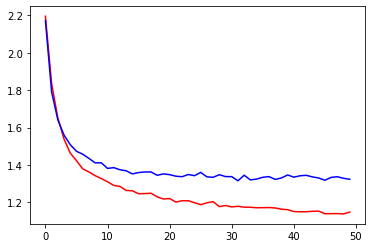

In [49]:
plt.plot(range(epochs),epoch_train,'r')
plt.plot(range(epochs),epoch_test,'b')
plt.show()